In [1]:
%run "..\Startup_py3.py"
sys.path.append(r"C:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

24092


# 0. required packages for h5py

In [2]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb',
             'save_folder':r'W:\Pu_Temp\20200707_IMR90_5kb_SI13',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20200803-Corrections_3color',
             'shared_parameters':{
                     'single_im_size':[30,2048,2048],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':200,
                     'max_num_seeds': 1000,
                     'spot_seeding_th':150,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,23)

In [5]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=True
intensity_th = 200

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.5, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 4.036s.
+ loading correction from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ base attri

C:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 138 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 66.358s.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.039s.
+ loading unique from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ finish loading unique in 0.020s. 
- start select from 138 chromosomes with loss threshold=0.5
-- remove chr id 3, percentage of lost rounds:1.000.
-- remove chr id 4, percentage of lost rounds:1.000.
-- remove chr id 5, percentage of lost rounds:1.000.
-- remove chr id 12, percentage of lost rounds:1.000.
-- remove chr id 19, percentage of lost rounds:1.000.
-- remove chr id 21, percentage of lost rounds:1.000.
-- remove chr id 21, percentage of lost rounds:1.000.
-- remove chr id 24, percentage of lost rounds:1.000.
-- remove chr id 33, percentage of lost rounds:1.000.
-- remove chr id 39, percentage of 

++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.381s.
+ loading correction from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_04.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_04.hdf5
++ base attributes loaded:[] in 0.007s.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_04.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'ma

-- remove chr id 3, percentage of lost rounds:0.989.
-- remove chr id 3, percentage of lost rounds:0.989.
-- remove chr id 3, percentage of lost rounds:0.989.
-- remove chr id 4, percentage of lost rounds:0.989.
-- remove chr id 5, percentage of lost rounds:0.989.
-- remove chr id 5, percentage of lost rounds:0.989.
-- remove chr id 5, percentage of lost rounds:0.989.
-- remove chr id 6, percentage of lost rounds:0.989.
-- remove chr id 6, percentage of lost rounds:0.989.
-- remove chr id 8, percentage of lost rounds:0.989.
-- remove chr id 9, percentage of lost rounds:0.989.
-- remove chr id 11, percentage of lost rounds:0.989.
-- remove chr id 13, percentage of lost rounds:0.989.
-- remove chr id 14, percentage of lost rounds:0.989.
-- remove chr id 15, percentage of lost rounds:0.989.
-- remove chr id 15, percentage of lost rounds:0.989.
-- remove chr id 15, percentage of lost rounds:0.989.
-- remove chr id 17, percentage of lost rounds:0.989.
-- remove chr id 19, percentage of lost

- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_05.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.593s.
+ loading correction from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_05.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_05.hdf5
++ base attributes loaded:[] in 0.008s.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_05.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chr

-- remove chr id 42, percentage of lost rounds:1.000.
-- remove chr id 42, percentage of lost rounds:1.000.
-- remove chr id 42, percentage of lost rounds:1.000.
-- remove chr id 42, percentage of lost rounds:1.000.
-- remove chr id 42, percentage of lost rounds:1.000.
-- remove chr id 43, percentage of lost rounds:1.000.
-- remove chr id 43, percentage of lost rounds:1.000.
-- remove chr id 45, percentage of lost rounds:1.000.
-- remove chr id 46, percentage of lost rounds:1.000.
-- remove chr id 46, percentage of lost rounds:1.000.
-- remove chr id 47, percentage of lost rounds:1.000.
-- remove chr id 49, percentage of lost rounds:1.000.
-- remove chr id 50, percentage of lost rounds:1.000.
-- remove chr id 51, percentage of lost rounds:1.000.
-- remove chr id 55, percentage of lost rounds:1.000.
-- remove chr id 58, percentage of lost rounds:1.000.
-- remove chr id 58, percentage of lost rounds:1.000.
-- remove chr id 58, percentage of lost rounds:1.000.
-- remove chr id 62, percent

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_06.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.352s.
+ loading correction from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_06.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_06.hdf5
++ base attri

-- remove chr id 16, percentage of lost rounds:0.989.
-- remove chr id 16, percentage of lost rounds:0.989.
-- remove chr id 16, percentage of lost rounds:0.989.
-- remove chr id 19, percentage of lost rounds:0.989.
-- remove chr id 21, percentage of lost rounds:0.989.
-- remove chr id 21, percentage of lost rounds:0.989.
-- remove chr id 26, percentage of lost rounds:0.989.
-- remove chr id 29, percentage of lost rounds:0.989.
-- remove chr id 29, percentage of lost rounds:0.989.
-- remove chr id 29, percentage of lost rounds:0.989.
-- remove chr id 40, percentage of lost rounds:0.989.
-- remove chr id 41, percentage of lost rounds:0.989.
-- remove chr id 41, percentage of lost rounds:0.989.
-- remove chr id 43, percentage of lost rounds:0.989.
-- remove chr id 44, percentage of lost rounds:0.989.
-- remove chr id 47, percentage of lost rounds:0.989.
-- remove chr id 48, percentage of lost rounds:0.989.
-- remove chr id 48, percentage of lost rounds:0.989.
-- remove chr id 54, percent

-- No folder selected, allow processing all 32 folders
-- checking unique, region:[1 2 3] in 0.047s.
-- checking unique, region:[4 5 6] in 0.012s.
-- checking unique, region:[7 8 9] in 0.011s.
-- checking unique, region:[10 11 12] in 0.032s.
-- checking unique, region:[13 14 15] in 0.034s.
-- checking unique, region:[16 17 18] in 0.027s.
-- checking unique, region:[19 20 21] in 0.015s.
-- checking unique, region:[22 23 24] in 0.011s.
-- checking unique, region:[25 26 27] in 0.026s.
-- checking unique, region:[28 29 30] in 0.033s.
-- checking unique, region:[31 32 33] in 0.011s.
-- checking unique, region:[34 35 36] in 0.011s.
-- checking unique, region:[37 38 39] in 0.010s.
-- checking unique, region:[40 41 42] in 0.010s.
-- checking unique, region:[43 44 45] in 0.011s.
-- checking unique, region:[46 47 48] in 0.010s.
-- checking unique, region:[49 50 51] in 0.010s.
-- checking unique, region:[52 53 54] in 0.017s.
-- checking unique, region:[55 56 57] in 0.011s.
-- checking unique, reg

-- remove chr id 36, percentage of lost rounds:0.978.
-- remove chr id 39, percentage of lost rounds:0.978.
-- remove chr id 47, percentage of lost rounds:0.978.
-- remove chr id 53, percentage of lost rounds:0.978.
-- remove chr id 58, percentage of lost rounds:0.978.
-- remove chr id 59, percentage of lost rounds:0.978.
-- remove chr id 59, percentage of lost rounds:0.978.
-- remove chr id 65, percentage of lost rounds:0.978.
-- remove chr id 65, percentage of lost rounds:0.978.
-- remove chr id 74, percentage of lost rounds:0.978.
-- remove chr id 2, percentage of lost rounds:0.968.
-- remove chr id 3, percentage of lost rounds:0.968.
-- remove chr id 7, percentage of lost rounds:0.968.
-- remove chr id 13, percentage of lost rounds:0.968.
-- remove chr id 15, percentage of lost rounds:0.968.
-- remove chr id 20, percentage of lost rounds:0.968.
-- remove chr id 27, percentage of lost rounds:0.968.
-- remove chr id 33, percentage of lost rounds:0.968.
-- remove chr id 44, percentage

- loading unique info from file:Conv_zscan_08.hdf5 in 4.462s.
-- shifting images in 67.278s. 
- loading unique info from file:Conv_zscan_08.hdf5 in 4.424s.
-- shifting images in 68.439s. 
- loading unique info from file:Conv_zscan_08.hdf5 in 4.435s.
-- shifting images in 68.941s. 
- loading unique info from file:Conv_zscan_08.hdf5 in 0.456s.
-- shifting images in 6.998s. 
-- finish generating chrom_im in 228.137s. 
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_08.hdf5
++ base attributes saved:[] in 1.430s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 169 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 79.852s.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_08.hdf5
++ base attributes saved:['cand_chro

-- remove chr id 30, percentage of lost rounds:0.946.
-- remove chr id 30, percentage of lost rounds:0.946.
-- remove chr id 32, percentage of lost rounds:0.946.
-- remove chr id 0, percentage of lost rounds:0.935.
-- remove chr id 4, percentage of lost rounds:0.935.
-- remove chr id 19, percentage of lost rounds:0.935.
-- remove chr id 16, percentage of lost rounds:0.925.
-- remove chr id 23, percentage of lost rounds:0.925.
-- remove chr id 26, percentage of lost rounds:0.925.
-- remove chr id 5, percentage of lost rounds:0.914.
-- remove chr id 17, percentage of lost rounds:0.914.
-- remove chr id 21, percentage of lost rounds:0.914.
-- remove chr id 0, percentage of lost rounds:0.903.
-- remove chr id 19, percentage of lost rounds:0.903.
-- remove chr id 1, percentage of lost rounds:0.892.
-- remove chr id 4, percentage of lost rounds:0.892.
-- remove chr id 5, percentage of lost rounds:0.892.
-- remove chr id 5, percentage of lost rounds:0.892.
-- remove chr id 4, percentage of lo

-- remove chr id 28, percentage of lost rounds:1.000.
-- remove chr id 29, percentage of lost rounds:1.000.
-- remove chr id 30, percentage of lost rounds:1.000.
-- remove chr id 30, percentage of lost rounds:1.000.
-- remove chr id 30, percentage of lost rounds:1.000.
-- remove chr id 32, percentage of lost rounds:1.000.
-- remove chr id 33, percentage of lost rounds:1.000.
-- remove chr id 38, percentage of lost rounds:1.000.
-- remove chr id 41, percentage of lost rounds:1.000.
-- remove chr id 41, percentage of lost rounds:1.000.
-- remove chr id 47, percentage of lost rounds:1.000.
-- remove chr id 47, percentage of lost rounds:1.000.
-- remove chr id 47, percentage of lost rounds:1.000.
-- remove chr id 47, percentage of lost rounds:1.000.
-- remove chr id 47, percentage of lost rounds:1.000.
-- remove chr id 49, percentage of lost rounds:1.000.
-- remove chr id 56, percentage of lost rounds:1.000.
-- remove chr id 56, percentage of lost rounds:1.000.
-- remove chr id 56, percent

-- remove chr id 7, percentage of lost rounds:0.817.
-- remove chr id 6, percentage of lost rounds:0.806.
-- remove chr id 8, percentage of lost rounds:0.796.
-- remove chr id 7, percentage of lost rounds:0.785.
-- remove chr id 7, percentage of lost rounds:0.785.
-- remove chr id 1, percentage of lost rounds:0.774.
-- remove chr id 8, percentage of lost rounds:0.742.
-- remove chr id 5, percentage of lost rounds:0.710.
-- remove chr id 3, percentage of lost rounds:0.688.
-- remove chr id 0, percentage of lost rounds:0.591.
-- remove chr id 3, percentage of lost rounds:0.581.
-- remove chr id 2, percentage of lost rounds:0.527.
-- 3 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_09.hdf5
++ base attributes saved:['chrom_coords'] in 0.040s.
kept chromosomes: 3
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\A

-- remove chr id 56, percentage of lost rounds:1.000.
-- remove chr id 56, percentage of lost rounds:1.000.
-- remove chr id 57, percentage of lost rounds:1.000.
-- remove chr id 62, percentage of lost rounds:1.000.
-- remove chr id 62, percentage of lost rounds:1.000.
-- remove chr id 64, percentage of lost rounds:1.000.
-- remove chr id 66, percentage of lost rounds:1.000.
-- remove chr id 66, percentage of lost rounds:1.000.
-- remove chr id 67, percentage of lost rounds:1.000.
-- remove chr id 77, percentage of lost rounds:1.000.
-- remove chr id 88, percentage of lost rounds:1.000.
-- remove chr id 88, percentage of lost rounds:1.000.
-- remove chr id 88, percentage of lost rounds:1.000.
-- remove chr id 92, percentage of lost rounds:1.000.
-- remove chr id 93, percentage of lost rounds:1.000.
-- remove chr id 99, percentage of lost rounds:1.000.
-- remove chr id 105, percentage of lost rounds:1.000.
-- remove chr id 108, percentage of lost rounds:1.000.
-- remove chr id 116, perc

-- remove chr id 3, percentage of lost rounds:0.882.
-- remove chr id 9, percentage of lost rounds:0.882.
-- remove chr id 10, percentage of lost rounds:0.882.
-- remove chr id 17, percentage of lost rounds:0.882.
-- remove chr id 9, percentage of lost rounds:0.871.
-- remove chr id 11, percentage of lost rounds:0.871.
-- remove chr id 12, percentage of lost rounds:0.860.
-- remove chr id 8, percentage of lost rounds:0.849.
-- remove chr id 8, percentage of lost rounds:0.849.
-- remove chr id 8, percentage of lost rounds:0.806.
-- remove chr id 3, percentage of lost rounds:0.796.
-- remove chr id 8, percentage of lost rounds:0.796.
-- remove chr id 8, percentage of lost rounds:0.774.
-- remove chr id 7, percentage of lost rounds:0.753.
-- remove chr id 0, percentage of lost rounds:0.731.
-- remove chr id 1, percentage of lost rounds:0.667.
-- remove chr id 3, percentage of lost rounds:0.667.
-- remove chr id 2, percentage of lost rounds:0.559.
-- 3 chromosomes are kept.
-- saving fov_i

-- remove chr id 72, percentage of lost rounds:1.000.
-- remove chr id 74, percentage of lost rounds:1.000.
-- remove chr id 76, percentage of lost rounds:1.000.
-- remove chr id 77, percentage of lost rounds:1.000.
-- remove chr id 80, percentage of lost rounds:1.000.
-- remove chr id 92, percentage of lost rounds:1.000.
-- remove chr id 106, percentage of lost rounds:1.000.
-- remove chr id 113, percentage of lost rounds:1.000.
-- remove chr id 114, percentage of lost rounds:1.000.
-- remove chr id 114, percentage of lost rounds:1.000.
-- remove chr id 114, percentage of lost rounds:1.000.
-- remove chr id 114, percentage of lost rounds:1.000.
-- remove chr id 117, percentage of lost rounds:1.000.
-- remove chr id 120, percentage of lost rounds:1.000.
-- remove chr id 121, percentage of lost rounds:1.000.
-- remove chr id 123, percentage of lost rounds:1.000.
-- remove chr id 128, percentage of lost rounds:1.000.
-- remove chr id 128, percentage of lost rounds:1.000.
-- remove chr id

-- remove chr id 3, percentage of lost rounds:0.742.
-- remove chr id 3, percentage of lost rounds:0.731.
-- remove chr id 3, percentage of lost rounds:0.688.
-- remove chr id 3, percentage of lost rounds:0.581.
-- remove chr id 2, percentage of lost rounds:0.527.
-- 3 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_11.hdf5
++ base attributes saved:['chrom_coords'] in 0.042s.
kept chromosomes: 3
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_12.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9

-- remove chr id 17, percentage of lost rounds:0.989.
-- remove chr id 23, percentage of lost rounds:0.989.
-- remove chr id 30, percentage of lost rounds:0.989.
-- remove chr id 33, percentage of lost rounds:0.989.
-- remove chr id 33, percentage of lost rounds:0.989.
-- remove chr id 36, percentage of lost rounds:0.989.
-- remove chr id 37, percentage of lost rounds:0.989.
-- remove chr id 41, percentage of lost rounds:0.989.
-- remove chr id 48, percentage of lost rounds:0.989.
-- remove chr id 51, percentage of lost rounds:0.989.
-- remove chr id 71, percentage of lost rounds:0.989.
-- remove chr id 75, percentage of lost rounds:0.989.
-- remove chr id 75, percentage of lost rounds:0.989.
-- remove chr id 75, percentage of lost rounds:0.989.
-- remove chr id 75, percentage of lost rounds:0.989.
-- remove chr id 80, percentage of lost rounds:0.989.
-- remove chr id 92, percentage of lost rounds:0.989.
-- remove chr id 4, percentage of lost rounds:0.978.
-- remove chr id 10, percenta

-- checking unique, region:[52 53 54] in 0.037s.
-- checking unique, region:[55 56 57] in 0.018s.
-- checking unique, region:[58 59 60] in 0.030s.
-- checking unique, region:[61 62 63] in 0.022s.
-- checking unique, region:[64 65 66] in 0.024s.
-- checking unique, region:[67 68 69] in 0.023s.
-- checking unique, region:[70 71 72] in 0.010s.
-- checking unique, region:[73 74 75] in 0.019s.
-- checking unique, region:[76 77 78] in 0.020s.
-- checking unique, region:[79 80 81] in 0.020s.
-- checking unique, region:[82 83 84] in 0.010s.
-- checking unique, region:[85 86 87] in 0.023s.
-- checking unique, region:[88 89 90] in 0.011s.
-- checking unique, region:[91 92 93] in 0.023s.
+ Start multi-processing of pre-processing for 31 images with 16 threads
++ processed unique ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 

-- remove chr id 57, percentage of lost rounds:0.989.
-- remove chr id 59, percentage of lost rounds:0.989.
-- remove chr id 63, percentage of lost rounds:0.989.
-- remove chr id 63, percentage of lost rounds:0.989.
-- remove chr id 68, percentage of lost rounds:0.989.
-- remove chr id 69, percentage of lost rounds:0.989.
-- remove chr id 71, percentage of lost rounds:0.989.
-- remove chr id 72, percentage of lost rounds:0.989.
-- remove chr id 79, percentage of lost rounds:0.989.
-- remove chr id 80, percentage of lost rounds:0.989.
-- remove chr id 86, percentage of lost rounds:0.989.
-- remove chr id 88, percentage of lost rounds:0.989.
-- remove chr id 90, percentage of lost rounds:0.989.
-- remove chr id 93, percentage of lost rounds:0.989.
-- remove chr id 93, percentage of lost rounds:0.989.
-- remove chr id 94, percentage of lost rounds:0.989.
-- remove chr id 95, percentage of lost rounds:0.989.
-- remove chr id 95, percentage of lost rounds:0.989.
-- remove chr id 96, percent

-- checking unique, region:[4 5 6] in 0.012s.
-- checking unique, region:[7 8 9] in 0.012s.
-- checking unique, region:[10 11 12] in 0.011s.
-- checking unique, region:[13 14 15] in 0.011s.
-- checking unique, region:[16 17 18] in 0.011s.
-- checking unique, region:[19 20 21] in 0.027s.
-- checking unique, region:[22 23 24] in 0.027s.
-- checking unique, region:[25 26 27] in 0.017s.
-- checking unique, region:[28 29 30] in 0.016s.
-- checking unique, region:[31 32 33] in 0.011s.
-- checking unique, region:[34 35 36] in 0.016s.
-- checking unique, region:[37 38 39] in 0.015s.
-- checking unique, region:[40 41 42] in 0.010s.
-- checking unique, region:[43 44 45] in 0.011s.
-- checking unique, region:[46 47 48] in 0.011s.
-- checking unique, region:[49 50 51] in 0.019s.
-- checking unique, region:[52 53 54] in 0.011s.
-- checking unique, region:[55 56 57] in 0.011s.
-- checking unique, region:[58 59 60] in 0.011s.
-- checking unique, region:[61 62 63] in 0.020s.
-- checking unique, region

-- remove chr id 50, percentage of lost rounds:0.978.
-- remove chr id 65, percentage of lost rounds:0.978.
-- remove chr id 67, percentage of lost rounds:0.978.
-- remove chr id 69, percentage of lost rounds:0.978.
-- remove chr id 69, percentage of lost rounds:0.978.
-- remove chr id 72, percentage of lost rounds:0.978.
-- remove chr id 1, percentage of lost rounds:0.968.
-- remove chr id 8, percentage of lost rounds:0.968.
-- remove chr id 8, percentage of lost rounds:0.968.
-- remove chr id 8, percentage of lost rounds:0.968.
-- remove chr id 8, percentage of lost rounds:0.968.
-- remove chr id 16, percentage of lost rounds:0.968.
-- remove chr id 24, percentage of lost rounds:0.968.
-- remove chr id 32, percentage of lost rounds:0.968.
-- remove chr id 38, percentage of lost rounds:0.968.
-- remove chr id 39, percentage of lost rounds:0.968.
-- remove chr id 42, percentage of lost rounds:0.968.
-- remove chr id 46, percentage of lost rounds:0.968.
-- remove chr id 46, percentage o

-- shifting images in 69.652s. 
- loading unique info from file:Conv_zscan_15.hdf5 in 4.585s.
-- shifting images in 68.001s. 
- loading unique info from file:Conv_zscan_15.hdf5 in 0.459s.
-- shifting images in 7.058s. 
-- finish generating chrom_im in 229.807s. 
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_15.hdf5
++ base attributes saved:[] in 1.440s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 149 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 71.847s.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_15.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.041s.
+ loading unique from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_15.hdf5
++ finish loading unique in 0.017s. 
- start select 

kept chromosomes: 3
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_16.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.532s.
+ loading correction from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_16.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_1

-- remove chr id 22, percentage of lost rounds:0.989.
-- remove chr id 30, percentage of lost rounds:0.989.
-- remove chr id 31, percentage of lost rounds:0.989.
-- remove chr id 31, percentage of lost rounds:0.989.
-- remove chr id 31, percentage of lost rounds:0.989.
-- remove chr id 33, percentage of lost rounds:0.989.
-- remove chr id 39, percentage of lost rounds:0.989.
-- remove chr id 45, percentage of lost rounds:0.989.
-- remove chr id 47, percentage of lost rounds:0.989.
-- remove chr id 51, percentage of lost rounds:0.989.
-- remove chr id 59, percentage of lost rounds:0.989.
-- remove chr id 59, percentage of lost rounds:0.989.
-- remove chr id 64, percentage of lost rounds:0.989.
-- remove chr id 64, percentage of lost rounds:0.989.
-- remove chr id 65, percentage of lost rounds:0.989.
-- remove chr id 66, percentage of lost rounds:0.989.
-- remove chr id 66, percentage of lost rounds:0.989.
-- remove chr id 67, percentage of lost rounds:0.989.
-- remove chr id 67, percent

++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.481s.
+ loading correction from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_17.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_17.hdf5
++ base attributes loaded:[] in 0.009s.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_17.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'ma

-- remove chr id 31, percentage of lost rounds:0.989.
-- remove chr id 31, percentage of lost rounds:0.989.
-- remove chr id 43, percentage of lost rounds:0.989.
-- remove chr id 48, percentage of lost rounds:0.989.
-- remove chr id 49, percentage of lost rounds:0.989.
-- remove chr id 53, percentage of lost rounds:0.989.
-- remove chr id 67, percentage of lost rounds:0.989.
-- remove chr id 67, percentage of lost rounds:0.989.
-- remove chr id 71, percentage of lost rounds:0.989.
-- remove chr id 76, percentage of lost rounds:0.989.
-- remove chr id 77, percentage of lost rounds:0.989.
-- remove chr id 77, percentage of lost rounds:0.989.
-- remove chr id 77, percentage of lost rounds:0.989.
-- remove chr id 83, percentage of lost rounds:0.989.
-- remove chr id 84, percentage of lost rounds:0.989.
-- remove chr id 84, percentage of lost rounds:0.989.
-- remove chr id 88, percentage of lost rounds:0.989.
-- remove chr id 97, percentage of lost rounds:0.989.
-- remove chr id 4, percenta

-- checking unique, region:[46 47 48] in 0.031s.
-- checking unique, region:[49 50 51] in 0.034s.
-- checking unique, region:[52 53 54] in 0.011s.
-- checking unique, region:[55 56 57] in 0.022s.
-- checking unique, region:[58 59 60] in 0.018s.
-- checking unique, region:[61 62 63] in 0.031s.
-- checking unique, region:[64 65 66] in 0.018s.
-- checking unique, region:[67 68 69] in 0.010s.
-- checking unique, region:[70 71 72] in 0.021s.
-- checking unique, region:[73 74 75] in 0.016s.
-- checking unique, region:[76 77 78] in 0.012s.
-- checking unique, region:[79 80 81] in 0.016s.
-- checking unique, region:[82 83 84] in 0.020s.
-- checking unique, region:[85 86 87] in 0.010s.
-- checking unique, region:[88 89 90] in 0.016s.
-- checking unique, region:[91 92 93] in 0.010s.
+ Start multi-processing of pre-processing for 31 images with 16 threads
++ processed unique ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39

-- remove chr id 29, percentage of lost rounds:0.978.
-- remove chr id 35, percentage of lost rounds:0.978.
-- remove chr id 47, percentage of lost rounds:0.978.
-- remove chr id 47, percentage of lost rounds:0.978.
-- remove chr id 48, percentage of lost rounds:0.978.
-- remove chr id 51, percentage of lost rounds:0.978.
-- remove chr id 58, percentage of lost rounds:0.978.
-- remove chr id 59, percentage of lost rounds:0.978.
-- remove chr id 71, percentage of lost rounds:0.978.
-- remove chr id 81, percentage of lost rounds:0.978.
-- remove chr id 3, percentage of lost rounds:0.968.
-- remove chr id 6, percentage of lost rounds:0.968.
-- remove chr id 7, percentage of lost rounds:0.968.
-- remove chr id 7, percentage of lost rounds:0.968.
-- remove chr id 9, percentage of lost rounds:0.968.
-- remove chr id 13, percentage of lost rounds:0.968.
-- remove chr id 13, percentage of lost rounds:0.968.
-- remove chr id 13, percentage of lost rounds:0.968.
-- remove chr id 25, percentage o

-- checking unique, region:[73 74 75] in 0.121s.
-- checking unique, region:[76 77 78] in 0.011s.
-- checking unique, region:[79 80 81] in 0.028s.
-- checking unique, region:[82 83 84] in 0.016s.
-- checking unique, region:[85 86 87] in 0.011s.
-- checking unique, region:[88 89 90] in 0.024s.
-- checking unique, region:[91 92 93] in 0.023s.
+ Start multi-processing of pre-processing for 31 images with 16 threads
++ processed unique ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93] in 2246.79s.
No forward chrom detected in color usage, generate chromosome with existing data
- Generate chromosome image from unique images, 93 images planned to load.
- loading unique info from file:Conv_zscan_19.hdf5 in 4.480s.
-- shifting images in 70.007s. 
- loading un

-- remove chr id 12, percentage of lost rounds:0.817.
-- remove chr id 5, percentage of lost rounds:0.806.
-- remove chr id 10, percentage of lost rounds:0.763.
-- remove chr id 3, percentage of lost rounds:0.753.
-- remove chr id 7, percentage of lost rounds:0.720.
-- remove chr id 1, percentage of lost rounds:0.710.
-- remove chr id 6, percentage of lost rounds:0.645.
-- remove chr id 2, percentage of lost rounds:0.624.
-- remove chr id 1, percentage of lost rounds:0.591.
-- remove chr id 1, percentage of lost rounds:0.591.
-- remove chr id 3, percentage of lost rounds:0.581.
-- 3 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_19.hdf5
++ base attributes saved:['chrom_coords'] in 0.039s.
kept chromosomes: 3
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '6

-- remove chr id 66, percentage of lost rounds:1.000.
-- remove chr id 69, percentage of lost rounds:1.000.
-- remove chr id 70, percentage of lost rounds:1.000.
-- remove chr id 73, percentage of lost rounds:1.000.
-- remove chr id 75, percentage of lost rounds:1.000.
-- remove chr id 76, percentage of lost rounds:1.000.
-- remove chr id 77, percentage of lost rounds:1.000.
-- remove chr id 77, percentage of lost rounds:1.000.
-- remove chr id 80, percentage of lost rounds:1.000.
-- remove chr id 84, percentage of lost rounds:1.000.
-- remove chr id 86, percentage of lost rounds:1.000.
-- remove chr id 86, percentage of lost rounds:1.000.
-- remove chr id 86, percentage of lost rounds:1.000.
-- remove chr id 87, percentage of lost rounds:1.000.
-- remove chr id 87, percentage of lost rounds:1.000.
-- remove chr id 89, percentage of lost rounds:1.000.
-- remove chr id 93, percentage of lost rounds:1.000.
-- remove chr id 95, percentage of lost rounds:1.000.
-- remove chr id 95, percent

kept chromosomes: 3
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_21.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.487s.
+ loading correction from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_21.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: W:\Pu_Temp\20200707_IMR90_5kb_SI13\Conv_zscan_2

-- remove chr id 16, percentage of lost rounds:0.989.
-- remove chr id 20, percentage of lost rounds:0.989.
-- remove chr id 31, percentage of lost rounds:0.989.
-- remove chr id 32, percentage of lost rounds:0.989.
-- remove chr id 36, percentage of lost rounds:0.989.
-- remove chr id 36, percentage of lost rounds:0.989.
-- remove chr id 36, percentage of lost rounds:0.989.
-- remove chr id 37, percentage of lost rounds:0.989.
-- remove chr id 46, percentage of lost rounds:0.989.
-- remove chr id 59, percentage of lost rounds:0.989.
-- remove chr id 60, percentage of lost rounds:0.989.
-- remove chr id 60, percentage of lost rounds:0.989.
-- remove chr id 66, percentage of lost rounds:0.989.
-- remove chr id 67, percentage of lost rounds:0.989.
-- remove chr id 68, percentage of lost rounds:0.989.
-- remove chr id 70, percentage of lost rounds:0.989.
-- remove chr id 70, percentage of lost rounds:0.989.
-- remove chr id 80, percentage of lost rounds:0.989.
-- remove chr id 92, percent

-- No folder selected, allow processing all 32 folders
-- checking unique, region:[1 2 3] in 0.076s.
-- checking unique, region:[4 5 6] in 0.012s.
-- checking unique, region:[7 8 9] in 0.011s.
-- checking unique, region:[10 11 12] in 0.011s.
-- checking unique, region:[13 14 15] in 0.011s.
-- checking unique, region:[16 17 18] in 0.011s.
-- checking unique, region:[19 20 21] in 0.011s.
-- checking unique, region:[22 23 24] in 0.026s.
-- checking unique, region:[25 26 27] in 0.019s.
-- checking unique, region:[28 29 30] in 0.011s.
-- checking unique, region:[31 32 33] in 0.010s.
-- checking unique, region:[34 35 36] in 0.010s.
-- checking unique, region:[37 38 39] in 0.019s.
-- checking unique, region:[40 41 42] in 0.021s.
-- checking unique, region:[43 44 45] in 0.022s.
-- checking unique, region:[46 47 48] in 0.022s.
-- checking unique, region:[49 50 51] in 0.024s.
-- checking unique, region:[52 53 54] in 0.011s.
-- checking unique, region:[55 56 57] in 0.011s.
-- checking unique, reg

-- remove chr id 20, percentage of lost rounds:0.989.
-- remove chr id 22, percentage of lost rounds:0.989.
-- remove chr id 27, percentage of lost rounds:0.989.
-- remove chr id 29, percentage of lost rounds:0.989.
-- remove chr id 29, percentage of lost rounds:0.989.
-- remove chr id 30, percentage of lost rounds:0.989.
-- remove chr id 30, percentage of lost rounds:0.989.
-- remove chr id 31, percentage of lost rounds:0.989.
-- remove chr id 33, percentage of lost rounds:0.989.
-- remove chr id 33, percentage of lost rounds:0.989.
-- remove chr id 35, percentage of lost rounds:0.989.
-- remove chr id 38, percentage of lost rounds:0.989.
-- remove chr id 40, percentage of lost rounds:0.989.
-- remove chr id 46, percentage of lost rounds:0.989.
-- remove chr id 48, percentage of lost rounds:0.989.
-- remove chr id 48, percentage of lost rounds:0.989.
-- remove chr id 54, percentage of lost rounds:0.989.
-- remove chr id 54, percentage of lost rounds:0.989.
-- remove chr id 64, percent

In [88]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 5000nm
intensity_th = 200
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 21.338s
-- collapse all regions into 1d.


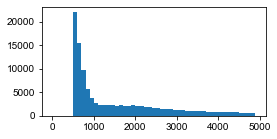

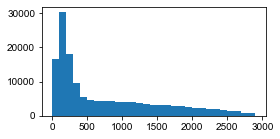

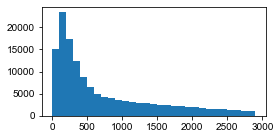

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 14.776s
-- region kept: 0.9129
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 18.394s
-- collapse all regions into 1d.


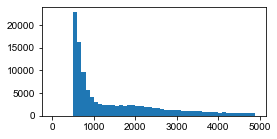

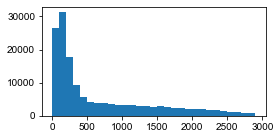

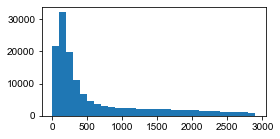

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 17.364s
-- region kept: 0.9747
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 18.692s
-- collapse all regions into 1d.


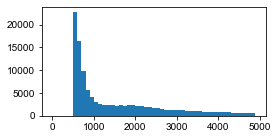

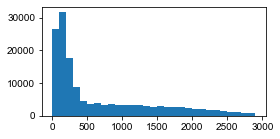

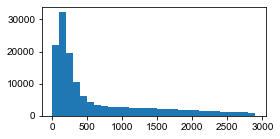

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 15.146s
-- region kept: 0.9948
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 18.579s
-- collapse all regions into 1d.


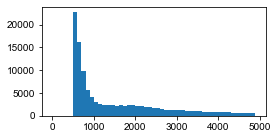

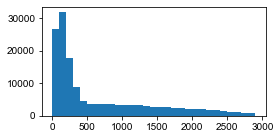

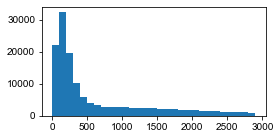

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 15.167s
-- region kept: 0.9980


In [89]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 12
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

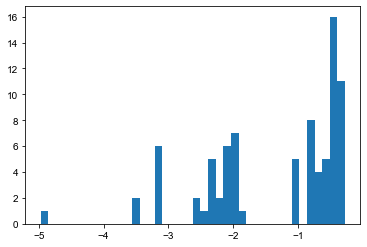

In [90]:
plt.figure()
plt.hist(np.log(sel_dna_scores_list[-1][1]), 40)
plt.show()

In [91]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = np.exp(-6)
int_th = 500
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    _kept_hzxys[_scores < score_th] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

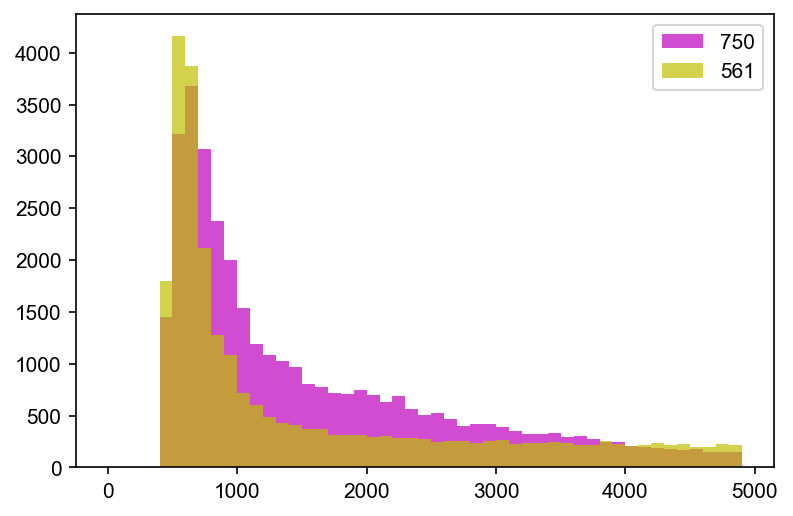

In [86]:
cy7_ints = np.array(final_dna_hzxys_list)[:,0::3,0]
cy5_ints = np.array(final_dna_hzxys_list)[:,1::3,0]
cy3_ints = np.array(final_dna_hzxys_list)[:,2::3,0]

plt.figure(dpi=150)
plt.hist(np.ravel(cy7_ints), bins=np.arange(0,5000, 100), 
         alpha=0.7, color='m', label='750')
#plt.hist(np.ravel(cy5_ints), bins=np.arange(0,5000, 100), 
#         alpha=0.7, color='r', label='647')
plt.hist(np.ravel(cy3_ints), bins=np.arange(0,5000, 100), 
         alpha=0.7, color='y', label='561')
plt.legend()
plt.show()

0.1408828821171037


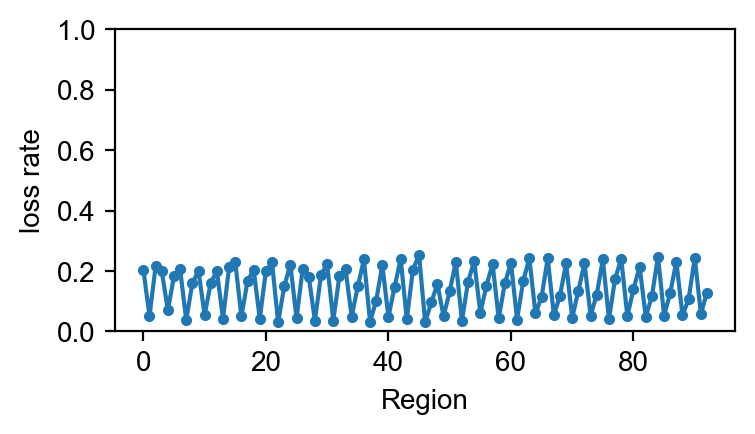

In [72]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,len(fov.unique_ids),20))
ax.set_ylim([0,1])
ax.set_ylabel(f"loss rate")
ax.set_xlabel(f"Region")
plt.show()

In [73]:
kept_inds = np.array([_i for _i in np.arange(len(median_distmap)) if _i%3 != 2])

In [45]:
kept_inds = np.where(loss_rates<0.5)[0]


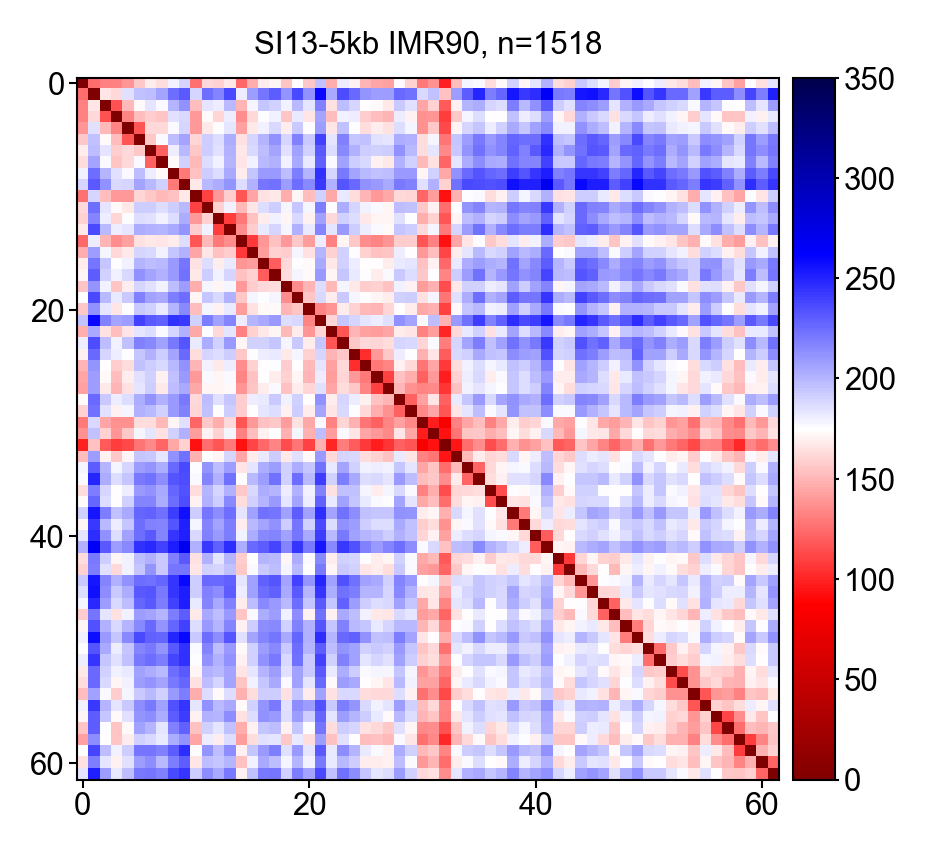

In [81]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
ax = ia.figure_tools.distmap.plot_distance_map(#median_distmap,
                                               median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,350],
                                               ax=ax,
                                               ticks=np.arange(0,len(fov.unique_ids),20), 
                                               figure_dpi=200)
ax.set_title(f"SI13-5kb IMR90, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

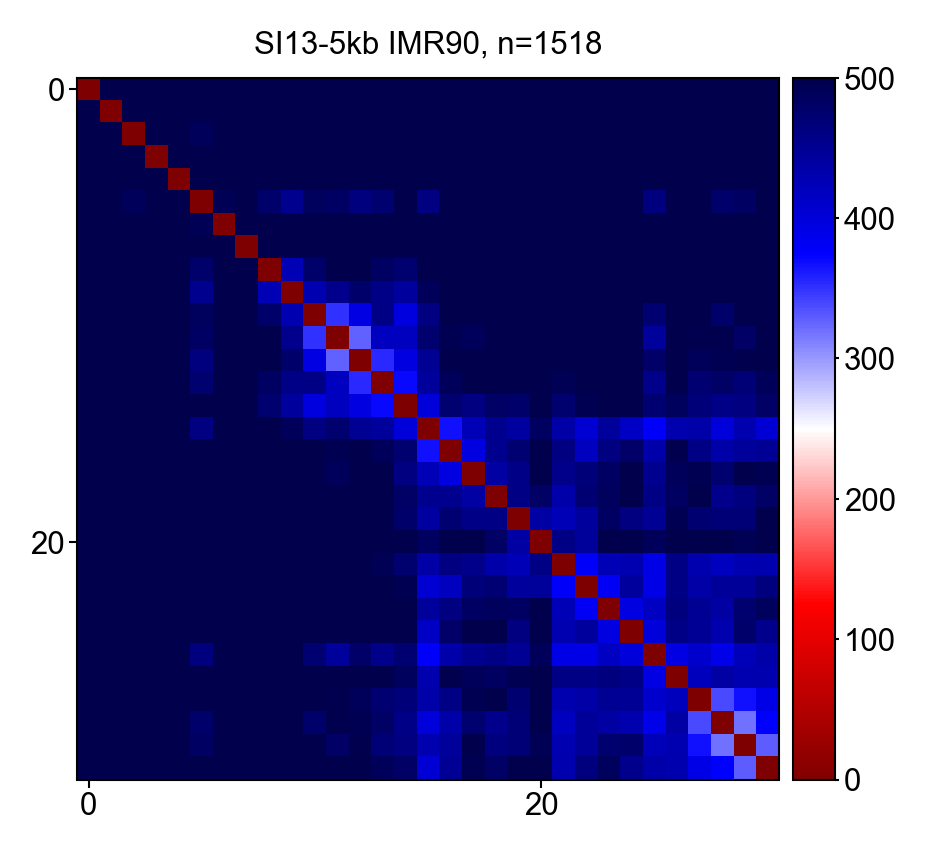

In [76]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
ax = ia.figure_tools.distmap.plot_distance_map(#median_distmap,
                                               median_distmap[2::3,2::3], 
                                               color_limits=[0,500],
                                               ax=ax,
                                               ticks=np.arange(0,len(fov.unique_ids),20), 
                                               figure_dpi=200)
ax.set_title(f"SI13-5kb IMR90, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

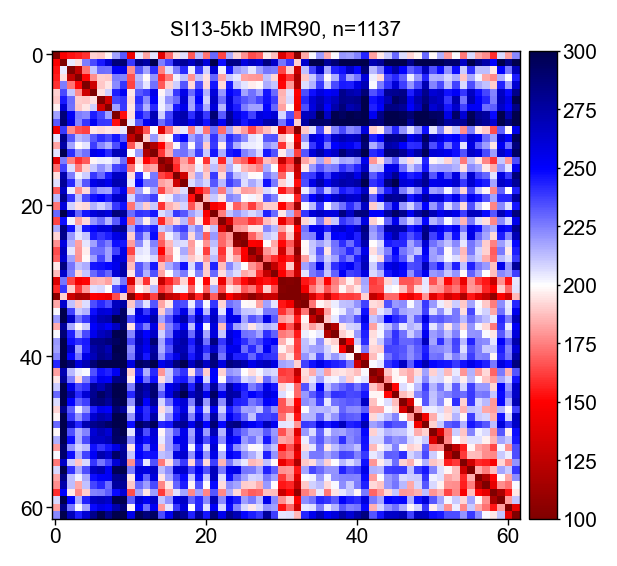

In [74]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#median_distmap,
                                               median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[100,300],
                                               ax=ax,
                                               ticks=np.arange(0,len(fov.unique_ids),20), 
                                               figure_dpi=200)
ax.set_title(f"SI13-5kb IMR90, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

###### 